In [1]:
%matplotlib notebook

In [2]:
import tdt
import numpy as np

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import matplotlib as mpl

from importlib import reload

from JM_general_functions import *
from JM_custom_figs import *
from helper_fx import *

### Change this to the filename you want to analyse

In [89]:
file = 'R:\\DA_and_Reward\\gc214\\dPP1\\tdt files\\08042019\\Giulia-190408-101326'
file = 'C:\\Raw Data Files\\Giulia-190408-101326'

In [90]:
# Initialize Session class
x = Session('Session to analyze')

### This line will read the file and can be modified to include less

In [91]:
x.tdtdata = tdt.read_block(file)

Found Synapse note file: C:\Raw Data Files\Giulia-190408-101326\Notes.txt
read from t=0s to t=2067.76s


In [92]:
x.ttls = vars(x.tdtdata.epocs)
print('TTLs = ', x.ttls.keys())

x.sigs = vars(x.tdtdata.streams)
print('Signals = ', x.sigs.keys())

TTLs =  dict_keys(['Tick', 'LT1_', 'RT2_', 'LL1_', 'RL2_'])
Signals =  dict_keys(['D4B2', 'D3B2', 'D2B2', 'D1B2', 'Fi2r'])


### To choose between box 1 and Box 2 and between different cohorts (where signals and TTLs are named differently), you will have to alter the names of the values here. Hint - all the values in the TDT file are printed above

In [129]:
# For Box 1
LickL = 'LL1_'
LickR = 'RL1_'
SipperL = 'LT1_'
SipperR = 'RT1_'

SigBlue = 'D1B2'
SigUV = 'D2B2'

# For Box 2
# LickL = 'LL2_'
# LickR = 'RL2_'
# SipperL = 'LT2_'
# SipperR = 'RT2_'

# SigBlue = 'D3B2'
# SigUV = 'D4B2'

In [130]:
tmp = getattr(x.tdtdata.streams, SigBlue)
x.fs = tmp.fs
x.data = tmp['data']

tmp2 = getattr(x.tdtdata.streams, SigUV)
x.dataUV = tmp2['data']

<IPython.core.display.Javascript object>


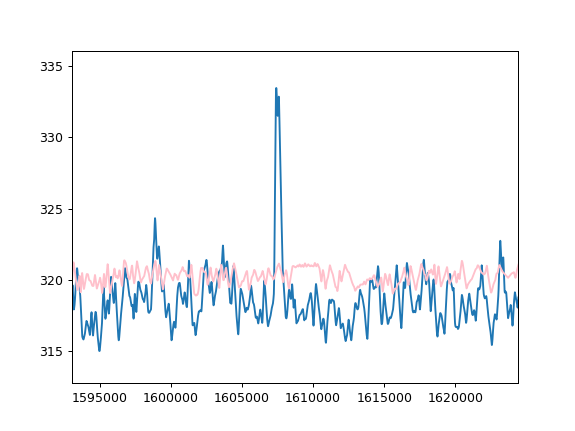

In [131]:
f, ax = plt.subplots()
ax.plot(x.data)
ax.plot(x.dataUV, 'pink');

### Helper functions for extracting data

In [132]:
x.tick = x.ttls['Tick'].onset # If this fails need to write new code to deal with files without Tick

In [133]:
maxsamples = len(x.tick)*int(x.fs)
if (len(x.data) - maxsamples) > 2*int(x.fs):
    print('Something may be wrong with conversion from time to samples')
    print(str(len(x.data) - maxsamples) + ' samples left over. This is more than double fs.')
    x.t2sMap = np.linspace(min(x.tick), max(x.tick), maxsamples)
else:
    x.t2sMap = np.linspace(min(x.tick), max(x.tick), maxsamples)

In [134]:
def event2sample(t2sMap, EOI):
    idx = (np.abs(t2sMap - EOI)).argmin()   
    return idx

In [135]:
x.left={}
try:
    lt = x.ttls[SipperL]
    x.left['exist'] = True
    x.left['sipper'] = lt.onset
    x.left['sipper_off'] = lt.offset
    ll = x.ttls[LickL]
    x.left['licks'] = np.array([i for i in ll.onset if i<max(x.left['sipper_off'])])
    x.left['licks_off'] = ll.offset[:len(x.left['licks'])]
except KeyError:
    x.left['exist'] = False
    x.left['sipper'] = []
    x.left['sipper_off'] = []
    x.left['licks'] = []
    x.left['licks_off'] = []
    
x.right={}
try:
    rt = x.ttls[SipperR]
    x.right['exist'] = True
    x.right['sipper'] = rt.onset
    x.right['sipper_off'] = rt.offset
    rl = x.ttls[LickR]
    x.right['licks'] = np.array([i for i in rl.onset if i<max(x.right['sipper_off'])])
    x.right['licks_off'] = rl.offset[:len(x.right['licks'])]
except KeyError:
    x.right['exist'] = False
    x.right['sipper'] = []
    x.right['sipper_off'] = []
    x.right['licks'] = []
    x.right['licks_off'] = []

In [136]:
# May need to add this in if we want to separate forced and free trials
# if self.left['exist'] == True and self.right['exist'] == True:
#     try:
#         first = findfreechoice(self.left['sipper'], self.right['sipper'])
#         self.both['sipper'] = self.left['sipper'][first:]
#         self.both['sipper_off'] = self.left['sipper_off'][first:]
#         self.left['sipper'] = self.left['sipper'][:first-1]
#         self.left['sipper_off'] = self.left['sipper_off'][:first-1]
#         self.right['sipper'] = self.right['sipper'][:first-1]
#         self.right['sipper_off'] = self.right['sipper_off'][:first-1]
#         self.left['licks-forced'], self.left['licks-free'] = dividelicks(self.left['licks'], self.both['sipper'][0])
#         self.right['licks-forced'], self.right['licks-free'] = dividelicks(self.right['licks'], self.both['sipper'][0])
#         self.left['nlicks-forced'] = len(self.left['licks-forced'])
#         self.right['nlicks-forced'] = len(self.right['licks-forced'])
#         self.left['nlicks-free'] = len(self.left['licks-free'])
#         self.right['nlicks-free'] = len(self.right['licks-free'])

#     except IndexError:
#         print('Problem separating out free choice trials')
# else:
#     self.left['licks-forced'] = self.left['licks']
#     self.right['licks-forced'] = self.right['licks']

In [137]:
try:
    x.left['lickdata'] = lickCalc(x.left['licks'],
                      offset = x.left['licks_off'],
                      burstThreshold = 0.50)
except IndexError:
    x.left['lickdata'] = 'none'

try:
    x.right['lickdata'] = lickCalc(x.right['licks'],
              offset = x.right['licks_off'],
              burstThreshold = 0.50)
except IndexError:
    x.right['lickdata'] = 'none'

In [138]:
# Could alter this code to set colors for each bottle and maybe work out which is casein
x.left['color'] = 'green'
x.right['color'] = 'blue'

In [139]:
def sessionlicksFig(ax):
    if x.left['exist'] == True:
        licks = x.left['lickdata']['licks']
        ax.hist(licks, range(0, 3600, 60), color=x.left['color'], alpha=0.4)          
        yraster = [ax.get_ylim()[1]] * len(licks)
        ax.scatter(licks, yraster, s=50, facecolors='none', edgecolors=x.left['color'])

    if x.right['exist'] == True:
        licks = x.right['lickdata']['licks']
        ax.hist(licks, range(0, 3600, 60), color=x.right['color'], alpha=0.4)          
        yraster = [ax.get_ylim()[1]] * len(licks)
        ax.scatter(licks, yraster, s=50, facecolors='none', edgecolors=x.right['color'])           
    
    ax.set_xticks(np.multiply([0, 10, 20, 30, 40, 50, 60],60))
    ax.set_xticklabels(['0', '10', '20', '30', '40', '50', '60'])
    ax.set_xlabel('Time (min)')
    ax.set_ylabel('Licks per min')

In [140]:
def behavFigsCol(gs1, col, side):
    ax = plt.subplot(gs1[1, col])
    licklengthFig(ax, side['lickdata'], color=side['color'])
    
    ax = plt.subplot(gs1[2, col])
    iliFig(ax, side['lickdata'], color=side['color'])
    
    ax = plt.subplot(gs1[3, col])
    cuerasterFig(ax, side['sipper'], side['lickdata']['licks'])

<IPython.core.display.Javascript object>


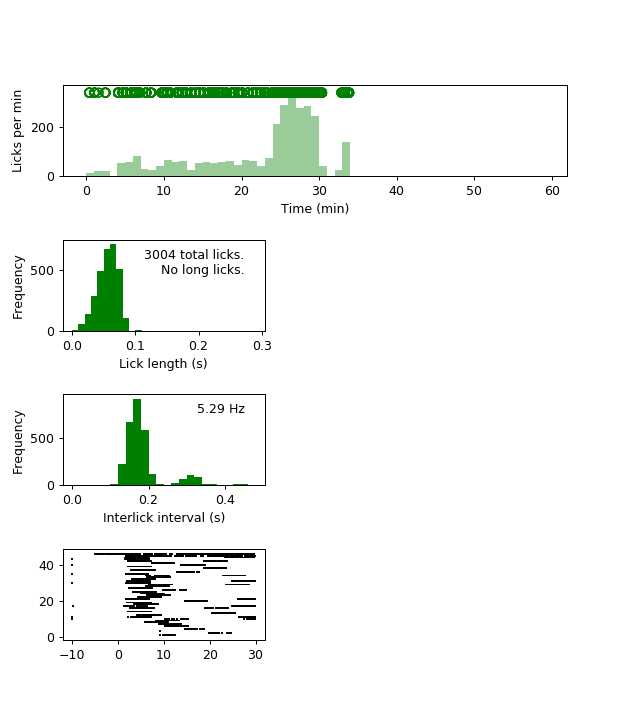

In [141]:
behavFig = plt.figure(figsize=(7,8))
gs1 = gridspec.GridSpec(4, 2)
gs1.update(left=0.10, right= 0.9, wspace=0.5, hspace = 0.7)

ax = plt.subplot(gs1[0, :])
sessionlicksFig(ax)

if x.left['exist'] == True:
    behavFigsCol(gs1, 0, x.left)

if x.right['exist'] == True:
    behavFigsCol(gs1, 1, x.right)

# ax = plt.subplot(gs1[4, 0])
# jmfig.latencyFig(ax, x)

In [124]:
bins = 300

x.randomevents = makerandomevents(120, max(x.tick)-120)
x.bgTrials, x.pps = snipper(x.data, x.randomevents,
                                t2sMap=x.t2sMap, fs=x.fs, bins=bins)

In [142]:
# Code to extract snips of data aligned to sipper and licking behaviour
for side in [x.left, x.right]:   
    if side['exist'] == True:
        side['snips_sipper'] = mastersnipper(x, side['sipper'], peak_between_time=[0, 5])
        side['snips_licks'] = mastersnipper(x, side['lickdata']['rStart'], peak_between_time=[0, 2])
        try:
            timelock_events = [licks for licks in side['lickdata']['rStart'] if licks in side['licks-forced']]
            latency_events = side['sipper']
            side['snips_licks_forced'] = jmf.mastersnipper(x, timelock_events, peak_between_time=[0, 2],
                                                            latency_events=latency_events, latency_direction='pre')
        except KeyError:
            pass
        try:
            side['lats'] = jmf.latencyCalc(side['lickdata']['licks'], side['sipper'], cueoff=side['sipper_off'], lag=0)
        except TypeError:
            print('Cannot work out latencies as there are lick and/or sipper values missing.')
            side['lats'] = []

No latency events found
No latency events found


In [143]:
def sessionFig(x, ax):
    ax.plot(x.data, color='blue', linewidth=0.1)
    try:
        ax.plot(x.dataUV, color='m', linewidth=0.1)
    except:
        print('No UV data.')
            
    ax.set_xticks(np.multiply([0, 10, 20, 30, 40, 50, 60],60*x.fs))
    ax.set_xticklabels(['0', '10', '20', '30', '40', '50', '60'])
    ax.set_xlabel('Time (min)')

In [144]:
def photoFigsCol(gs1, col, pps, snips_sipper, snips_licks):
    ax = plt.subplot(gs1[2, col])
    trialsFig(ax, snips_sipper['blue'], pps, noiseindex = snips_sipper['noise'],
                    eventText = 'Sipper',
                    ylabel = 'Delta F / F0')
    
    ax = plt.subplot(gs1[3, col])
    trialsMultShadedFig(ax, [snips_sipper['uv'], snips_sipper['blue']],
                              pps, noiseindex = snips_sipper['noise'],
                              eventText = 'Sipper')
    
    ax = plt.subplot(gs1[2, col+1])
    shadedError(ax, snips_sipper['blue_z'])
    
    ax = plt.subplot(gs1[4, col])
    trialsFig(ax, snips_licks['blue'], pps, noiseindex=snips_licks['noise'],
                    eventText = 'First Lick',
                    ylabel = 'Delta F / F0')
    
    ax = plt.subplot(gs1[5, col])
    trialsMultShadedFig(ax, [snips_licks['uv'], snips_licks['blue']],
                              pps, noiseindex=snips_licks['noise'],
                              eventText = 'First Lick')
    
    ax = plt.subplot(gs1[4, col+1])
    shadedError(ax, snips_licks['blue_z'])

<IPython.core.display.Javascript object>


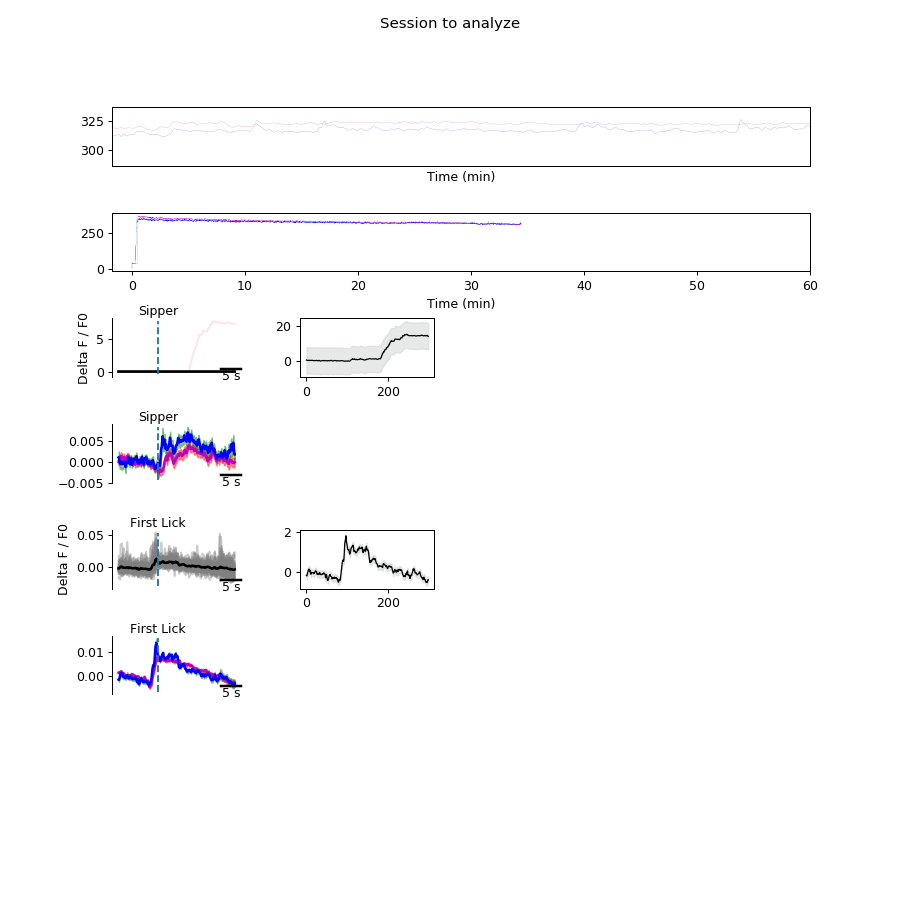

In [145]:
photoFig = plt.figure(figsize=(10, 10), dpi=100)
gs1 = gridspec.GridSpec(7, 4)
gs1.update(left=0.125, right= 0.9, wspace=0.4, hspace = 0.8)
plt.suptitle(x.sessionID)

ax = plt.subplot(gs1[0, :])
sessionFig(x, ax)

ax = plt.subplot(gs1[1, :])
sessionFig(x, ax)

if x.left['exist'] == True:
    photoFigsCol(gs1, 0, x.pps,
                 x.left['snips_sipper'],
                 x.left['snips_licks'])

if x.right['exist'] == True:
    photoFigsCol(gs1, 2, x.pps,
                 x.right['snips_sipper'],
                 x.right['snips_licks'])

# if x.left['exist'] == True and x.right['exist'] == True:
#     ax = plt.subplot(gs1[6, 0])
#     jmfig.trialsMultShadedFig(ax, [x.left['snips_sipper']['diff'], x.right['snips_sipper']['diff']],
#                               x.pps,
#                               linecolor=[x.left['color'], x.right['color']],
#                               eventText = 'Sipper')

#     ax = plt.subplot(gs1[6, 2])
#     jmfig.trialsMultShadedFig(ax, [x.left['snips_licks']['diff'], x.right['snips_licks']['diff']],
#                               x.pps,
#                               linecolor=[x.left['color'], x.right['color']],
#                               eventText = 'Lick')